<a href="https://colab.research.google.com/github/git-ekeh/baseline_guided_transformer/blob/master/summarizer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting my Google Drive to access the file directory from this notebook**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**Installing Tensorflow as Deep Learning Library of choice, along with various libraries to aid in the text preprocessing**


In [ ]:
!pip install tensorflow-text
!pip install tensorflow_datasets
!pip install protobuf==3.20.*

In [ ]:
!pip3 install tensorflow as tf
!pip3 install transformers
!pip3 install spacy
!pip3 install datasets
!pip3 install numpy as np
!pip3 install matplotlib

In [ ]:
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections
import itertools
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf
import pickle
import datasets
import transformers
from transformers import DataCollatorWithPadding
from transformers import BertTokenizer, AutoTokenizer
from transformers import DataCollatorWithPadding
from datasets import load_dataset, Dataset

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

**I used a custom algorithm I developed for my master's thesis to annotate the XSUM dataset with a guidance feature, using TextRank and an 8 Core CPU and stored them in separate dictionaries for later use.**

In [ ]:
#import train and val dictionaries
import pickle

with open('/content/gdrive/MyDrive/U of T Data Science Masters /Thesis_Summer_2023/code/validation_dictionary.pkl', 'rb') as file:
    validation_data = pickle.load(file)

validation_dict = validation_data

print(validation_dict['0'])
print(len(validation_dict))
print(type(validation_dict))


with open('/content/gdrive/MyDrive/U of T Data Science Masters /Thesis_Summer_2023/code/train_dict.pkl', 'rb') as file:
  train_data = pickle.load(file)

train_dict = train_data

print(train_dict['0'])
print(len(train_dict))
print(type(train_dict))


{'id': '38295789', 'document': 'The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian sport.\nMr Sodje, 37, is jointly charged with elder brothers Efe, 44, Bright, 50 and Stephen, 42.\nAppearing at the Old Bailey earlier, all four denied the offence.\nThe charge relates to offences which allegedly took place between 2008 and 2014.\nSam, from Kent, Efe and Bright, of Greater Manchester, and Stephen, from Bexley, are due to stand trial in July.\nThey were all released on bail.', 'summary': 'Former Premier League footballer Sam Sodje has appeared in court alongside three brothers accused of charity fraud.', 'guidance': ['charges', 'Bright', 'Sodje', 'Sports', 'Foundation', 'Efe', 'trading', 'Stephen', 'defender', 'charity', 'brothers', 'Greater']}
11332
<class 'dict'>
{'id': '35232142', 'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair

# **Data cleaning and transformation**

In [ ]:
# Convert dictionaries to dataframes and transpose them to get the appropriate features of the dataframes

df_train = pd.DataFrame.from_dict(train_dict)
df_val = pd.DataFrame.from_dict(validation_dict)

transpose_df_train = df_train.T
transpose_df_val = df_val.T



In [ ]:
# pickle the tensors in a separate file
# Convert the dataframe rows to lists to avoid error: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
transpose_df_train['id'] = transpose_df_train['id'].values.tolist()
transpose_df_train['document'] = transpose_df_train['document'].values.tolist()
transpose_df_train['summary'] = transpose_df_train['summary'].values.tolist()
transpose_df_train['guidance'] = transpose_df_train['guidance'].values.tolist()

transpose_df_val['id'] = transpose_df_val['id'].values.tolist()
transpose_df_val['document'] = transpose_df_val['document'].values.tolist()
transpose_df_val['summary'] = transpose_df_val['summary'].values.tolist()
transpose_df_val['guidance'] = transpose_df_val['guidance'].values.tolist()

# Convert Dataframes to Datasets
dataset_train = Dataset.from_pandas(transpose_df_train)
dataset_val = Dataset.from_pandas(transpose_df_val)

dataset_train = dataset_train.remove_columns("__index_level_0__")
dataset_train = dataset_train.remove_columns("id")
dataset_val = dataset_val.remove_columns("__index_level_0__")
dataset_val = dataset_val.remove_columns("id")

print(dataset_train)
print(dataset_val)

Dataset({
    features: ['document', 'summary', 'guidance'],
    num_rows: 204045
})
Dataset({
    features: ['document', 'summary', 'guidance'],
    num_rows: 11332
})


**The guidance feature is represented by the words in parentheses**

In [ ]:
print(dataset_train[1]['document'])
print(dataset_train[1]['summary'])
print(dataset_train[1]['guidance'])

A fire alarm went off at the Holiday Inn in Hope Street at about 04:20 BST on Saturday and guests were asked to leave the hotel.
As they gathered outside they saw the two buses, parked side-by-side in the car park, engulfed by flames.
One of the tour groups is from Germany, the other from China and Taiwan. It was their first night in Northern Ireland.
The driver of one of the buses said many of the passengers had left personal belongings on board and these had been destroyed.
Both groups have organised replacement coaches and will begin their tour of the north coast later than they had planned.
Police have appealed for information about the attack.
Insp David Gibson said: "It appears as though the fire started under one of the buses before spreading to the second.
"While the exact cause is still under investigation, it is thought that the fire was started deliberately."
Two tourist buses have been destroyed by fire in a suspected arson attack in Belfast city centre.
['buses', 'fire', '

In [ ]:
#Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token


batch_size = 8 # this is for full training
encoder_max_length = 512
decoder_max_length = 128
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

print(tokenizer.bos_token)
print(tokenizer.eos_token)
print(len(tokenizer))
#print(tokenizer.attention_mask)

[CLS]
[SEP]
30522


**Processing the document, summary, and guidance features separately**

In [ ]:
def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(batch["document"],  padding="max_length", truncation=True, max_length=encoder_max_length)
    outputs = tokenizer(batch["summary"], padding="max_length", truncation=True, max_length=decoder_max_length)

    #Concatenate guidance strings using the [SEP] token
    guidance_text = ["[SEP]".join(guidance) for guidance in batch["guidance"]]
    guidance = tokenizer(guidance_text, padding="max_length", truncation=True, max_length=encoder_max_length)


    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["guidance_inputs"] = guidance.input_ids
    batch["guidance_attention_mask"] = guidance.attention_mask
    batch["decoder_input_ids"] = outputs.input_ids
    batch["decoder_attention_mask"] = outputs.attention_mask

    # Use decoder_inputs as the label, since BERT automatically shifts the labels
    batch["labels"] = outputs.input_ids.copy()

    # because BERT automatically shifts the labels, the labels correspond exctly to `decoder_input_ids`
    # We have to make sure that he PAD token is ignored
    batch["labels"] = [[0 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

    return batch


**Converting data to a huggingface dataset, splitting the data into a training and validation dataset**

In [ ]:
dataset_train = dataset_train.map(process_data_to_model_inputs,
                                  batched=True,
                                  batch_size = batch_size)
dataset_val = dataset_val.map(process_data_to_model_inputs,
                                  batched=True,
                                  batch_size = batch_size)

Map:   0%|          | 0/204045 [00:00<?, ? examples/s]

Map:   0%|          | 0/11332 [00:00<?, ? examples/s]

In [ ]:
print(dataset_train[0])

{'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally apprecia

In [ ]:
# Converting the recently tokenized data into a tensorflow dataset
dataset_train = dataset_train.to_tf_dataset(
    columns=["input_ids","attention_mask","guidance_inputs","guidance_attention_mask","decoder_input_ids", "decoder_attention_mask", "labels"],
    label_cols=["labels"],
    batch_size = 8,
    collate_fn=data_collator,
    shuffle=True
)

dataset_val = dataset_val.to_tf_dataset(
    columns=["input_ids","attention_mask","guidance_inputs","guidance_attention_mask","decoder_input_ids", "decoder_attention_mask", "labels"],
    label_cols=["labels"],
    batch_size = 8,
    collate_fn=data_collator,
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
print(len(dataset_val))
print(len(dataset_train))
# model is over fitting but the batche sizes are correct and look different
# 11332 length of data set val 355 * (batch_size) = 11360...one batch is less than 32
# 204045 length of data set train 6377 * (batch_size) = 204064... one batch is less than 32

1417
25506


# **Model Development**

This model is a transformer developed from scratch in TensorFlow. My inspiration is from the GSum: A General Framework for Guided Neural Abstractive Summarizations written by Dou et al. in 2021. The gitHub page for the model can be found here: https://github.com/neulab/guided_summarization. After a month of attempting to implement the model from the repository, I decided it would be more beneficial for my learning to build the model on my own. I opted to build the model from scratch because I wanted to learn each major component of the transformer's architecture and how it all fit together.

**Positional Encoding and Positional Embedding layers**

In [ ]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth # (1, depth)

    angle_rates = 1 / (10000**depths) #(1, depth)
    angle_rads = positions * angle_rates #(pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the emebdding and positional_encoding
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

**Attention mechanisms**

Attention is arguably the most important aspect of the transformer. I would say it is the most fascinating part of the architecture. Thank you tensorflow for providing a pre-built multiheadattion mechanism to use out of the box. Although I am interested in building attention mechanisms from scratch, but for the purpose of this model it was slightly unnessessary.

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

'''
The cross attention layer:

---> At the literal center for the Transformer is the cross-attention layer. This layer connects the
     encoder and decoder. This layer is the most straight-forward use of attention in the model

---> To implement this you pass the target sequence x as the query and the context sequence as the
     key/value when calling the mha layer
'''

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

'''
The global self attention layer:

---> The global self attention layer on the other hand lets every sequence element directly access every
     other sequence element, with only a few operations, and all the outputs can be computed in parallel
---> To implement thi layer your just need to pass the target sequence, x, as both the query, and value
     arguments to the mha layer
'''

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

'''
The causal self attention layer:

---> To build a causal self attention layer, you need to use an appropriate mask when computing scores
     and summing the attention value S
---> This is taken care of automatically if you pass `use_causal_mask = True` to the MultiHeadAttention layer when it is called
---> Ther causal mask ensure that each location only has access to the locations that come before it
'''

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x



class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])

        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

**Encoder layer & Encoder**

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)

        return x

class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
                         for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x) # Shape `(batch_size, seq_len, d_model)`

        # Add dropout
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x #Shape `(batch_size, seq_len, d_model)`

**Decoder Layer & Decoder**

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention0 = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention1 = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context0, context1):
        # gotta build two cross attention mechanisms, one for guidance and one for source doc
        x = self.causal_self_attention(x=x)

        guidance = self.cross_attention0(x=x, context=context0)

        source = self.cross_attention1(x=guidance, context=context1)


        # Cache the last attention scores for plotting later
        #self.last_attn_scores = self.cross_attention.last_attn_scores

        final = self.ffn(source)  # Shape `(batch_size, seq_len, d_model)`.
        return final # instead of x


class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
                        for _ in range(num_layers)]
        self.last_attn_scores = None

    def call(self, x, context0, context1):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x) # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context0, context1)

        #self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model)
        return x

**Transformer**

I used two encoders, one to encode the guidance signal and the other to encode the source document, I pass both to the decoder with the goal of passing the cross attention mechanism as much information about the document as possible. The goal is to guide the output of the model through feeding it guidance tokens. This is a variant on the original transformer from the GSUM paper, which is actually a variant of the transformer from Attention is All you Need Vashwani et. al (2017).

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder0 = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)
        self.encoder1 = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):

        #if isinstance(inputs, dict):
        document = inputs['input_ids']
        guidance = inputs['guidance_inputs']
        output = inputs['decoder_input_ids']
        '''
        else:
            document, guidance, output = inputs
        '''


        # Process the document and guidance features in parallel through the two encoders
        context0 = self.encoder0(document)
        context1 = self.encoder1(guidance)

        x = self.decoder(output, context0, context1)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it does not scale the losses/metrics
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights
        return logits

**Hyper-parameters**

I settled on these hyperparameters after various iterations of fine-tuning.

In [ ]:
''' HYPERPARAMETERS '''

num_layers = 2 # from 5 to 8
d_model = 128
num_heads = 1
dff = 512
input_vocab_size = 50000
target_vocab_size = 50000
dropout_rate = 0.3
epochs = 30

**Training metrics**

In [ ]:
''' MASKED LOSS + MASKED ACCURACY + OPTIMIZER '''

''' TRAINING '''

# Set up the loss metrics

def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0
    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


In [ ]:
''' CONSTRUCTION OF THE MODEL + CALLBACKS'''

model = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                    input_vocab_size=input_vocab_size, target_vocab_size = target_vocab_size,
                    dropout_rate=dropout_rate)

model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
# Use a callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

working_dir = '/content'  # Replace this with your working directory path
file_name = 'weights.{epoch:02d}-val_loss_{val_loss:.2f}-val_masked_acc_{val_masked_accuracy:.2f}.hdf5'  # The file name format with placeholders for epoch and validation loss

# Construct the checkpoint file path
filepath = os.path.join(working_dir, 'ckpt', file_name)

checkpoint_filepath = os.path.join(working_dir, 'ckpt', filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_masked_accuracy',
    verbose = 1,
    save_best_only = True,
    mode = 'auto',
    save_freq = 'epoch'
)


In [ ]:
'''TRAIN MODEL '''
history = model.fit(dataset_train, epochs=epochs, validation_data=dataset_val, callbacks=[callback, model_checkpoint_callback])


Epoch 1/30
25506/25506 [==============================] - ETA: 0s - loss: 1.2122 - masked_accuracy: 0.8794
Epoch 1: val_masked_accuracy improved from -inf to 0.93137, saving model to /content/ckpt/weights.01-val_loss_0.77-val_masked_acc_0.93.hdf5
25506/25506 [==============================] - 1823s 70ms/step - loss: 1.2122 - masked_accuracy: 0.8794 - val_loss: 0.7749 - val_masked_accuracy: 0.9314
Epoch 2/30
25506/25506 [==============================] - ETA: 0s - loss: 0.8618 - masked_accuracy: 0.9245
Epoch 2: val_masked_accuracy improved from 0.93137 to 0.93417, saving model to /content/ckpt/weights.02-val_loss_0.77-val_masked_acc_0.93.hdf5
25506/25506 [==============================] - 1605s 63ms/step - loss: 0.8618 - masked_accuracy: 0.9245 - val_loss: 0.7714 - val_masked_accuracy: 0.9342
Epoch 3/30
25506/25506 [==============================] - ETA: 0s - loss: 0.8495 - masked_accuracy: 0.9274
Epoch 3: val_masked_accuracy did not improve from 0.93417
25506/25506 [===================

**Visuals**

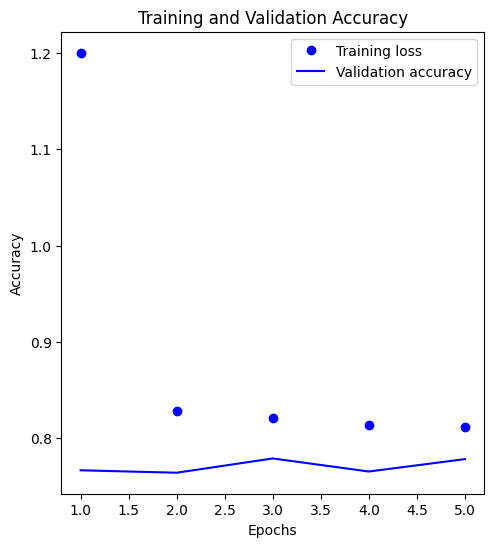

In [ ]:
# Get some visualizations
history_dict = history.history
'''
#This should provide a dictionary with keys like:
 #- 'loss'
 #- 'accuracy'
 #- 'val_loss'
 #- 'val_accuracy'
'''



def plot_training_history(history_dict):
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    accuracy = history_dict['masked_accuracy']
    val_accuracy = history_dict['val_masked_accuracy']
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_training_history(history_dict)


**Generating a Summary**

Used the Bert Tokenizer's decode to convert the predicted ID's back to tokens

In [ ]:
# Generating a summary

class Summarizer:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, document, max_length=128):
        if not isinstance(document, str):
            document = tf.constant(document, dtype=tf.string)
            if len(document.shape) == 0:
                document = document[tf.newaxis]
            document = document.numpy().tolist()[0].decode('utf-8')

        inputs = self.tokenizer(document, return_tensors='tf', padding=True, truncation=True)
        encoder_input = inputs['input_ids'] # fuzzy...there is no input_id in the document I pass into the model
        guidance_input = tf.zeros_like(encoder_input) # fuzzy why create the same tensor with zeros

        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, tf.constant([self.tokenizer.bos_token_id], dtype=tf.int64))

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.model({'input_ids': encoder_input, 'guidance_inputs': guidance_input, 'decoder_input_ids': output}, training=False)
            predictions = predictions[:, -1, :]
            predicted_id = tf.argmax(predictions, axis=-1, output_type=tf.int64)
            if tf.reduce_all(predicted_id == self.tokenizer.eos_token_id):
                break
            output_array = output_array.write(i + 1, predicted_id)

        tokens = output_array.stack()
        summary = self.tokenizer.decode(tokens.numpy().squeeze())
        return summary, tokens


summarizer = Summarizer(model = model, tokenizer = tokenizer)

input_text = train_dict['0']['document']
print("Document:", input_text)

summary, tokens = summarizer(input_text)
print("Summary:", summary)

Document: The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - bu

**Results**

As you can see from the graph, the results of my summarizer were not the greatest. The summary largely consisted of the [CLS] token and one or two words repeated consistently. Despite these results, I realized that building a model from scratch with no pre-training strategy will always result in a model that will stray from accurate results. I did not use the masked langugae training technique or the causal language training technique. I provided a transformer built from scratch, with a little over 200,000 examples and guidance signals. Many open-source models use at least 5 times the amount of examples I have. Anyways, this was a fun experience, regardless of the results.